# <center>Валидация данных</center>

В предыдущих модулях по машинному обучению тот набор данных, на котором мы проверяли качество построенной модели, мы называли **тестовым набором данных (testing data)**. Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется **двухкомпонентным**.

Ранее мы использовали тестовый набор не только для проверки итогового качества, но и для подбора внешних параметров. Мы выбирали оптимальные пороги вероятности и коэффициенты регуляризации, при которых наблюдался максимум целевой метрики (мы использовали $F_{1}$-меру). 

Однако такой подход не совсем корректен, ведь мы подстраивали модель под тестовую выборку, то есть по сути занимались небольшим самообманом. Тестовая выборка должна быть «независимым судьёй», который объективно и непредвзято «выносит приговор» нашей модели.

Из-за этого в больших *Data Science*-проектах используются не два, а три набора данных: в дополнение к тренировочному и тестовому наборам данных выделяется **валидационный набор (validation data)**. Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется трёхкомпонентным.

Итак, существуют **три основных вида выборок**, которые используются в машинном обучении:

1) **Обучающая (тренировочная)** — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).

2) **Валидационная (проверочная)** — набор данных, на котором мы оцениваем промежуточные результаты обучения. Основная цель создания такого набора данных — отслеживание переобучения. На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т.д.

3) **Тестовая (контрольная)** — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров. С помощью этого набора осуществляется окончательная проверка качества. Главное условие для тестовой выборки — она должна быть независимой от обучающей.

Тестирование — это попытка что-то выяснить, а валидация — доказать, что что-то является истиной (в нашем случае — доказать, что качество модели на валидационной выборке совпадает с качеством при обучении). Важная концепция, которую необходимо сохранить, состоит в том, что **окончательный набор** (называемый тестом или валидацией) не используется в процессе обучения модели, а **используется исключительно для оценки её качества**.

Процесс проверки предсказательной способности модели машинного обучения называется **валидацией**.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — *Potability* (пригодность для питья): 1 — вода пригодна, 0 — вода непригодна для питья.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [3]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (*ph*), около 24 % — о содержании сульфатов (*Sulfate*) и около 5 % — о тригалометанах (*Trihalomethanes*). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (*Potability*). Для этого сгруппируем данные по признаку *Potability*, посчитаем медиану в каждой группе, а затем отправим результат в метод `fillna()`:

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [5]:
#Убедимся в отсутствии пропусков
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [6]:
#Разделим набор данных на матрицу наблюдений X и вектор правильных ответов y
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

## <center>HOLD-OUT</center>

Метод **hold-out (отложенная выборка)** нам уже знаком. Это самый простой и очень популярный метод. Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию). Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-2_7.png)

**<u>Преимущества:</u>**
* Очень простой и понятный.
* Чаще всего применяется на больших датасетах, так как требует значительно меньше вычислительных мощностей, чем другие методы.

**<u>Недостатки:</u>**
* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться, и оценка качества может быть необъективной.

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле `model_selection`, мы импортировали его заранее.

Метод *hold-out* реализован в уже знакомой вам функции `train_test_split()`. Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

**Основные параметры `train_test_split()`:**

* `*arrays` — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, *numpy*-массивы, *DataFrame*), которые подлежат разбиению.

* `test_size` — размер тестовой (валидационной) выборки. Может быть указан в долях. Если параметр `train_size` задан дробным числом с плавающей точкой, то параметр `test_size` определяется автоматически как `1-train_size`.

* `train_size` — размер тренировочной выборки. Может быть указан в долях. Если параметр `test_size` задан дробным числом с плавающей точкой, то параметр `train_size` определяется автоматически как `1-test_size`.

* `random_state` — число, на основе которого производится генерация случайных чисел.

* `shuffle` — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию `True`).

* `stratify` — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

Если мы используем **двухкомпонентный подход** (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию `train_test_split()` и передать в неё матрицу наблюдений `X` и вектор-столбец с правильными ответами `y`.

Для примера разделим выборку в соотношении 80/20 (`test_size=0.2`), в качестве значения параметра `random_state` по традиции возьмём число 42.

In [7]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Проверим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Далее нам останется только обучить модель на тренировочной выборке (`X_train`, `y_train`) и рассчитать метрики на валидационной выборке (`X_valid`, `y_valid`).

В качестве модели будем использовать *дерево решений* с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — *accuracy*.

In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем **трёхкомпонентный подход** (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в *sklearn* нет специализированного функционала для такого разбиения.

Применим функцию `train_test_split()` дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [10]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [11]:
#Выводим размерности
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

## <center>K-FOLD</center>

Метод **k-fold** более известен как **кросс-валидация (cross validation)**, или **перекрёстный контроль**. Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

**Алгоритм кросс-валидации:**

1) Разбить исходную выборку на $k$ частей — **фолдов (fold)**.

2) Повторять $k$ раз:
    * Обучить модель на $k-1$ частях. Назовём их **тренировочными фолдами (training fold)**. 
    * Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её **валидационным фолдом (validation fold)**.

3) Усреднить значения метрики на валидационных фолдах.

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-2_8.png)

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из $k$ частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения $k$ часто берут 10, то есть выборка разбивается на десять фолдов. В случае маленьких выборок $k$ берут равным 3 или 5.

Чем больше $k$, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

**Преимущества:**
* Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.

* Значения метрик получаются более объективными, ведь мы обучаем одну модель $k$ раз — у нас получается $k$ независимых друг от друга значений метрики.

**Недостатки:**
* Подход предусматривает, что мы обучаем одну и ту же модель $k$ раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

*<u>Примечание:</u>*
Мы оцениваем метрику не по одному значению на валидационной выборке, как это было в *hold-out*, а по $k$ значений. Если $k$ достаточно велико, можно даже построить гистограмму и оценить, в каких пределах находится истинное качество. Однако на практике этим занимаются крайне редко, так как такие вычисления очень времязатратны.

В библиотеке *sklearn* метод *k-fold* реализован в классе `KFold`.

**Основные параметры инициализатора `KFold`:**

* `n_split` — число фолдов (число $k$ из метода *k-fold*). По умолчанию — 5.

* `shuffle` — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — `False`.

* `random_state` — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса `KFold` есть метод `split()`. В данный метод необходимо передать матрицу наблюдений `X` и вектор-столбец ответов `y` — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу *k-fold*.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект `KFold` для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл `for` для получения элементов из генератора, созданного с помощью метода `split()`. На каждой итерации в переменных `train_index` и `valid_index` будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

* выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
* обучать дерево решений;
* делать предсказания для текущих тренировочной и валидационной выборок;
* рассчитывать метрику *accuracy* на текущих выборках и заносить её значение в список.

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [13]:
#Выведем содержимое массивов train_metrics и val_metrics
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [14]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — `cross_validate()` из модуля `model_selection`. Она организует процедуру кросс-валидации и расчёт метрик.

**Основные параметры функции `cross_validate()`:**

* `estimator` — модель, качество которой будет проверяться на кросс-валидации.
* `X` — матрица наблюдений.
* `y` — вектор-столбец правильных ответов.
* `cv` — кросс-валидатор из библиотеки *sklearn* (например, `KFold`) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* `scoring` — название метрики в виде строки либо функция для её вычисления (`'accuracy'`, `'precision'`, `'recall'`, `'f1'` и другие; полный список — в документации к функции).
* `return_train_score` — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — `False`, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* `fit_time` — время обучения модели на каждой итерации кросс-валидации;
* `score_time` — время вычисления метрик на каждой итерации кросс-валидации;
* `test_score` — значения метрик на валидационных фолдах;
* `train_score` — значения метрик на тренировочных фолдах.

In [15]:
#Итоговый код с использованием функции
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.0263958 , 0.03142619, 0.02165532, 0.02850389, 0.01450396]),
 'score_time': array([0.00182605, 0.00600266, 0.        , 0.        , 0.01455235]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам `train_score` и `test_score`, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [16]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


## <center>LEAVE-ONE-OUT</center>

Метод **leave-one-out (отложенный пример)**, или **поэлементная кросс-валидация** — это частный случай кросс-валидации (*k-fold*), когда размер $k$ равняется размеру всей выборки $k=n$, где $n$ — количество примеров (строк в таблице).

**Алгоритм метода:**

1) Повторять $n$ раз:
    * Выбрать один случайный пример для валидации.
    * Обучить модель на всех оставшихся $n-1$ примерах.
    * Произвести оценку качества (вычислить метрику) на отложенном примере.
2) Усреднить значение метрик на всех примерах.

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-2_10.png)

**Преимущества:**
* Идеально подходит для небольших датасетов (менее 100 примеров).
* Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.

**Недостатки:**
* Подход предусматривает, что мы обучаем одну и ту же модель $n$ раз. Очевидно, что чем больше примеров в обучающем наборе данных, тем больше моделей мы будем обучать. Поэтому метод не подходит для оценки качества модели на больших наборах данных, поскольку становится очень ресурсозатратным.

В библиотеке *sklearn* метод *leave-one-out* реализован в классе `LeaveOneOut`. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с `KFold`, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса `LeaveOneOut` также можно передать в функцию `cross_validate()` для получения метрик на каждом из примеров. В случае с метрикой *accuracy* список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации *leave-one-out* будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

In [17]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


**Примечание**

Метод *leave-one-out* можно реализовать и без использования специального класса — достаточно просто указать параметр `n_split=n` в инициализаторе `KFold`, где `n` — количество строк в таблице.

## <center>Дисбаланс выборки</center>

**Несбалансированный набор данных (unbalanced dataset)** — это выборка, в которой количества примеров каждого из классов значительно отличаются.

* класс большинства называется **мажоритарным (majority)** классом;
* класс меньшинства называется **миноритарным (minority)** классом.

**Проблемы, которые могут возникнуть из-за несбалансированной выборки:**

* При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.

* Нельзя использовать метрики, не учитывающие размеры классов, такие как *accuracy*. Данную проблему мы обсуждали, когда знакомились с метриками классификации.

* Стандартные методы *ML*, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

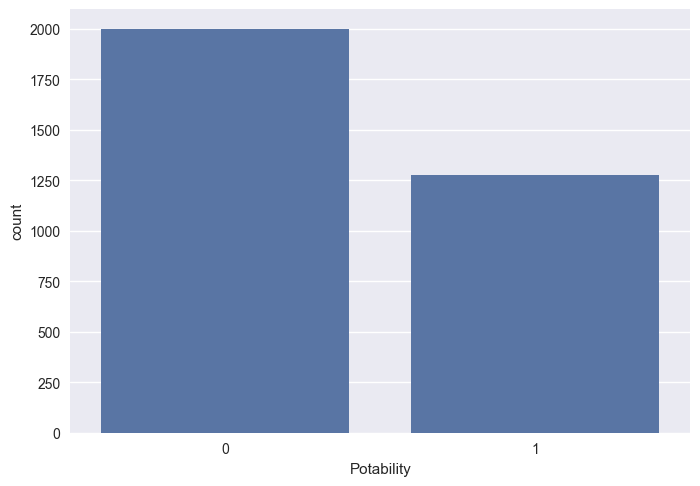

In [18]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

## <center>Стратифицированное разбиение</center>

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [19]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid:
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


Для стратифицированного разбиения достаточно в функции `train_test_split()` задать параметр `stratify`, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами `y`.

In [20]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


Чтобы организовать разбиение по методу *k-fold* и получить одинаковые соотношения классов вместо `KFold` используется кросс-валидатор `StratifiedKFold`. Принцип работы с ним аналогичен, только, в отличие от `KFold`, `StratifiedKFold` будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

In [21]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


Так же, как и другие кросс-валидаторы, объект класса `StratifiedKFold` может быть использован в функции `cross_validate()`.

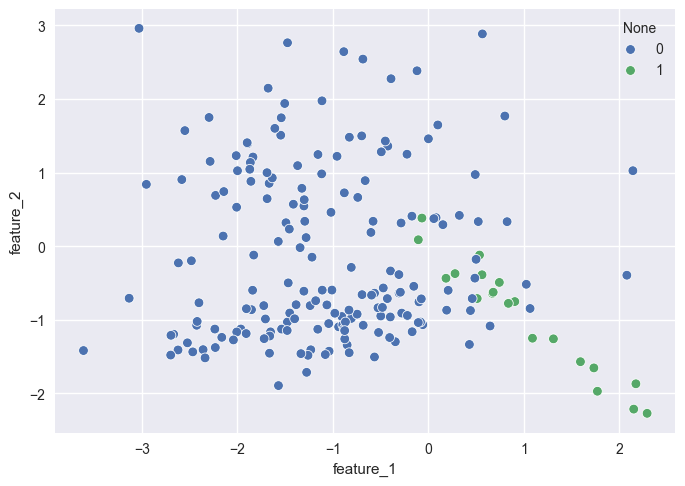

In [22]:
# Задание 3.3

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

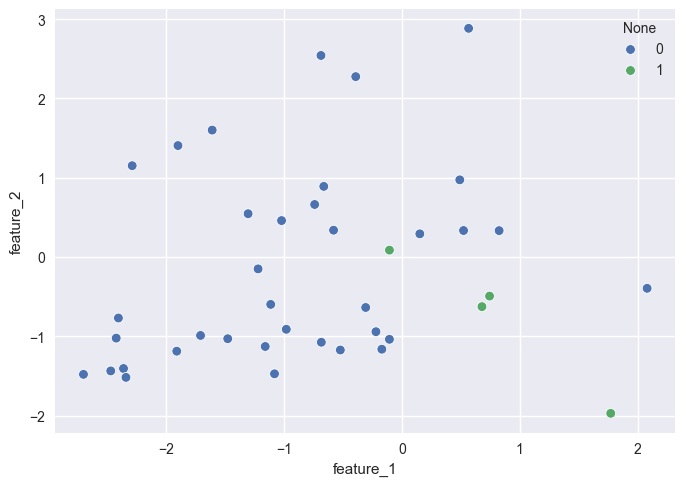

In [23]:
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

## <center>Выбор метрик в условиях дисбаланса</center>

Основной представитель таких метрик — это знакомая нам *accuracy*, доля угаданных моделью ответов. Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации *precision*, *recall* и *$F_{1}$-score*.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции `classification_report()`.

In [24]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



* *Precision* для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.

* *Recall* для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.

* *$F_{1}$-мера* — среднее гармоническое между *precision* и *recall* — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику *accuracy*. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

**Примечание** 

Поскольку простая *accuracy* вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это *функционал Каппа Коэна (Cohen’s Kappa)* и *balanced accuracy*.

In [25]:
# Задание 3.5

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_valid_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



## <center>Построение модели в условиях дисбаланса</center>

Существует **несколько способов уменьшить влияние дисбаланса на обучение модели**:

* **Взвешивание объектов**. В функцию ошибки добавляется штраф, обратно пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.

* **Выбор порога вероятности**. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, *$F_{1}$-score*).

* **Сэмплирование (sampling)** — перебалансировка выборки искусственным путём:
    * **oversampling** — искусственное увеличение количества объектов миноритарного класса;
    * **undersampling** — сокращение количества объектов мажоритарного класса.

Здесь могут использоваться алгоритмы генерации искусственных данных, такие как *NearMiss*, *SMOTE* (Synthetic Minority Oversampling Techniques) и *ADASYN* (Adaptive Synthetic).

## <center>Взвешивание объектов</center>

Большинство моделей, реализованных в *sklearn*, имеют параметр `class_weight` — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

$$class \ weight(majority) = 1$$

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

$$class \ weight(minority) = 1 + \frac{n_{majority}}{n_{minority}}$$

Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр `class_weight='balanced'`.

In [26]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [27]:
# Задание 3.7

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
log_reg_balanced = linear_model.LogisticRegression(class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)
y_valid_pred = log_reg_balanced.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

#Из-за ошибки ответ не сходится
#Должно быть
#Accuracy: 0.82
#F1-score для класса 0: 0.90
#F1-score для класса 1: 0.46

              precision    recall  f1-score   support

           0       0.66      0.54      0.59       400
           1       0.44      0.56      0.49       256

    accuracy                           0.55       656
   macro avg       0.55      0.55      0.54       656
weighted avg       0.57      0.55      0.55       656



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## <center>Выбор порога вероятности, PR-кривая</center>

Следующий метод, о котором мы поговорим, — это выбор **порога вероятности (бинаризации)**.

Мы знаем, что любой классификатор предсказывает для объектов вероятности их принадлежности к классу 1 ($\hat{P}$) и классу 0 ($Q=1-\hat{P}$). Класс объекта по умолчанию определяется по следующему правилу:
* Если вероятность $\hat{P} > 0.5$, то объект относится моделью к классу 1.
* Если вероятность $\hat{P} \leq 0.5$, то объект относится моделью к классу 0.

Однако из модуля по классификации мы также знаем, что данный порог можно поменять. Это является очень распространённой практикой, ведь для каждой задачи может быть свой оптимальный порог вероятности.

**PR-кривая (precision-recall curve)** — это график зависимости precision от recall при различных значениях порога вероятности.

Для построения данного графика мы берём множество различных порогов вероятности (0.1, 0.15, 0.2, …1) и вычисляем метрики *precision* и *recall* при разных порогах вероятности. Если мы построим линейный график зависимости *precision* от *recall*, то получим примерно следующую картину:

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-3_17.png)

**Что нам даёт такая кривая?**

1) *PR*-кривая — это графическая метрика качества модели, она комплексно отражает и *precision*, и *recall* одновременно (как $F_{1}$-мера) и особенно хороша в условиях дисбаланса классов.

    Качество определяется площадью (*PR AUC*) под кривой: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь равна 1. У такой модели и *precision*, и *recall* равны 1. Конечно же, таких моделей не существует в природе. Если площадь под *PR*-кривой меньше 0.5, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

2) С помощью *PR*-кривой удобно находить оптимальный порог вероятности. Главное — определиться с критерием этой оптимальности. На кривой мы можем найти такие точки, в которых наблюдается наилучшее значение *precision* или *recall* или среднее гармоническое между ними ($F_{1}$-score). 

Подберём порог вероятности с помощью *PR*-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики $F_{1} = \frac{2 * precision * recall}{(recall + precision)}$ для класса 1 (питьевая вода).

Перед построением *PR*-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию `cross_val_predict()`. Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр `method='predict_proba'`, она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции `cross_validate()`.

In [28]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [29]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить *PR*-кривую. Для этого воспользуемся функций `precision_recall_curve()` из модуля `metrics` библиотеки *sklearn*. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик *precision* и *recall*, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [30]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение $F_{1}$-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции `argmax()` из модуля `numpy` — она возвращает индекс максимального элемента массива.

Далее построим *PR*-кривую и отметим на ней точку максимума $F_{1}$-score.

Best threshold = 0.33, F1-Score = 0.69


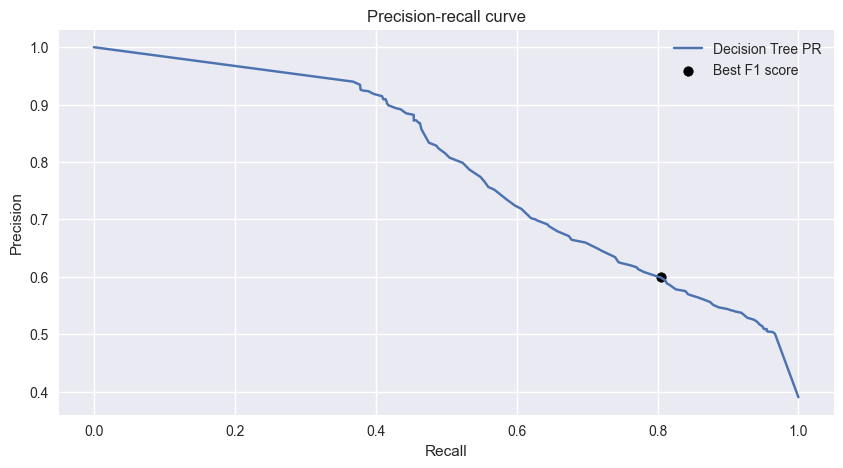

In [31]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной *PR*-кривой, максимум $F_{1}$ (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [32]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Итак, при применении метода подбора вероятности увеличилось значение метрик *recall* и $F_{1}$ для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

**Примечание**

Чтобы вычислить площадь под *PR*-кривой, используется функция `auc()` из модуля `metrics` библиотеки *sklearn*. В данную функцию нужно передать значения метрик *recall* и *precision* при различных порогах вероятности:

In [33]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


## <center>Сэмплирование</center>

**Сэмплирование**, а точнее — **пересэмплирование (oversampling)**.

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество. Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм *SMOTE* (Synthetic Minority Oversampling Techniques). В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их.

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-3_24.png)

Алгоритмов сэмплирования, в том числе *SMOTE*, нет в стандартном пакете *sklearn* — они содержатся в библиотеке `imblearn` (imbalanced-learn). Команды для установки приведены далее.

Для пользователей *pip*:

`!pip install imbalanced-learn`

Все алгоритмы пересэмплирования находятся в модуле `over_sampling` библиотеки `imblearn`. Импортируем оттуда алгоритм `SMOTE`:

In [34]:
from imblearn.over_sampling import SMOTE

Создадим объект класса `SMOTE` и вызовем у него метод `fit_resample()`, передав в него обучающую выборку (`X_train`, `y_train`). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [35]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
Potability
0    1598
1    1022
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
Potability
0    1598
1    1598
Name: count, dtype: int64


Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [36]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Нам удалось поднять метрики для класса 1 на валидационной выборке и снова найти баланс между метриками классов. Однако мы потеряли в метриках для класса 0.

In [37]:
# Задание 3.11

X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)

X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid= model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
log_reg_smote = linear_model.LogisticRegression(class_weight='balanced')
log_reg_smote.fit(X_train_s, y_train_s)
y_valid_pred = log_reg_smote.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



На самом деле плохая различающая способность может быть связана не только с дисбалансом выборки. На качество моделирования влияют и другие факторы:

* **Сложность модели**. Выбранная нами модель дерева решений является довольно простым классификатором. Имеет смысл задуматься над применением более сложных методов, например случайного леса.
* **Недостаток информации**. Вполне возможно, признаков, описывающих химический состав воды, попросту недостаточно, чтобы точно сказать, пригодна ли она для питья.
* **Качество данных**. В представленных данных возможно наличие зашумлённой информации — выбросов и аномальных образцов воды.

Полезно помнить: хорошие признаки и правильно подобранная модель — вот что самое главное в *ML*. Всё остальное — второстепенно.

# <center>Недообучение и переобучение. Утечка данных</center>

Важной характеристикой алгоритма машинного обучения является его **обобщающая способность** — способность использовать знания, полученные при обучении, на новых данных. Обобщающая способность часто страдает из-за двух основных проблем машинного обучения: **overfitting (переобучение)** и **underfitting (недообучение)**.

**Переобучение (overfitting)** — это проблема, при которой модель чувствительна к незначительным колебаниям в данных в процессе обучения. По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

**Недообучение (underfitting)** — это проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

Недообучение и переобучение неразрывно связаны друг с другом: попытка бороться с одной проблемой может привести к возникновению другой, поэтому возникает **дилемма смещения-разброса (bias-variance tradeoff)**. 

**Смещение (bias)** — это математическое ожидание (обозначено далее как ) разности между истинным ответом и ответом, выданным моделью. То есть это ожидаемая ошибка модели. 

$$bias(\hat{y}) = E \left [ (y - \hat{y}) \right ]$$

**Разброс (variance)** — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели (обозначено далее как $E$). 

$$variance(\hat{y}) = Var \left [ (y - \hat{y}) \right ]$$

В случае регрессии:

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-4_1.png)

В случае классификации:

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-4_2.png)

## <center>Обнаружение переобучения</center>

Переобучение легко детектируется с помощью изученных нами методов валидации: мы намеренно разбиваем выборку на тренировочную и валидационную (возможно, и тестовую) и смотрим на значения показателей на каждой из выборок, сравнивая их между собой.

**Основные способы отследить переобучение:**

* *hold-out*-разбиение,
* *k-fold*-валидация и *leave-one-out*-валидация,
* кривые обучения (*learning curves*).

Если качество на валидационной выборке стабильно хуже качества на тренировочной, то это явный признак переобучения.

In [38]:
#Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.60


In [39]:
#Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.00652838, 0.        , 0.        , 0.        , 0.00806189]),
 'score_time': array([0.        , 0.00802875, 0.00889039, 0.        , 0.00105357]),
 'test_score': array([0.8       , 0.85714286, 0.75      , 0.57142857, 0.88888889]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [40]:
#Подсчитаем среднее значение F1-score на выборках
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.77


Train accuracy: 0.98
Valid accuracy: 0.82


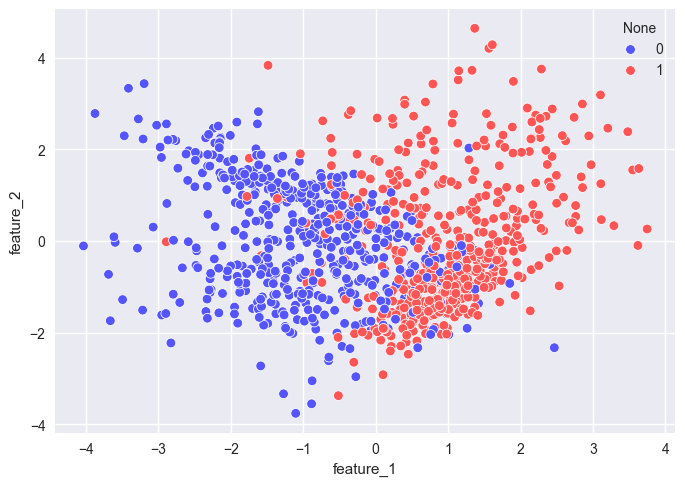

In [41]:
# Задание 4.3

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

## <center>Борьба с переобучением</center>

Ключевая идея, заложенная в каждом из методов, звучит так: **снизить переобучение = уменьшить разброс (вариативность) ошибки модели**:

1) **Уменьшение сложности модели**

    * Для **линейной (логистической) регрессии** с полиномиальными признаками уменьшение сложности модели означает понижение степени полинома.
    * Для **деревьев решений** — «стрижка» (*pruning*) деревьев, то есть уменьшение их глубины (`max_depth`) и/или увеличение количества объектов, при которых вершина дерева превращается в лист (`min_samples_leaf`).
    * Для **случайного леса** — «стрижка» деревьев (`max_depth` и `min_samples_leaf`) и уменьшение количества признаков, на которых обучается каждое дерево (`max_features`).

2) **Регуляризация**

    С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

3) **Манипуляции с данными**

    Ещё один верный способ побороть переобучение — увеличить или уменьшить количество примеров, на которых обучается модель.

In [42]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


Train accuracy: 0.88
Valid accuracy: 0.85


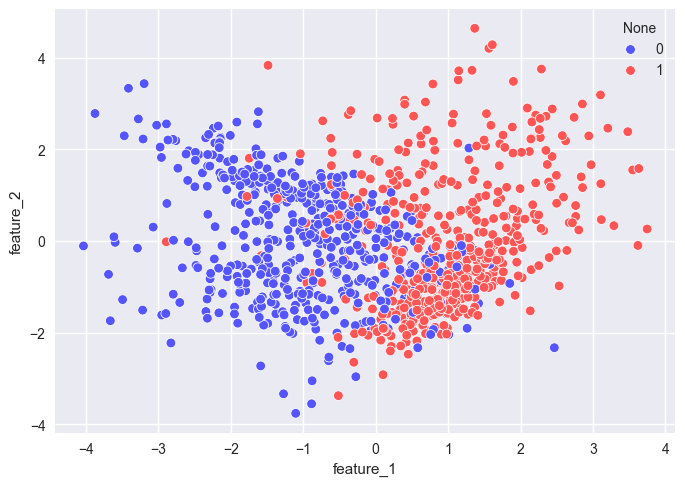

In [43]:
# Задание 4.6

from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

## <center>Утечка данных</center>

**Утечка данных (data leak)** — это ситуация, в которой данные, используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной.

**Примеры, когда может возникнуть утечка данных:**

1) **Очевидные случаи**

    * включение целевой переменной, которую мы пытаемся предсказать, в качестве фактора;
    * включение тестовых данных в данные по обучению модели, а затем использование этих же тестовых данных для оценки качества модели.

2) **Скрытые случаи, или giveaway-признаки**

    **Giveaway** — это признаки, которые раскрывают информацию о целевой переменной и не будут доступны после развёртывания модели в реальных условиях. Такие признаки необходимо удалять из данных перед построением модели.

# <center>Кривая обучения (learning curve)</center>

**Кривая обучения (learning curve)** — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.

Если мы построим график эволюции метрики, по которой измеряем качество модели, по мере добавления всё новых и новых данных, мы получим примерно следующие кривые:

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml5-5_5.png)

**Что нам дают такие кривые?**

1) Основное назначение кривых обучения — мониторинг изменения метрики в процессе поступления новых данных. Благодаря этому мы можем найти такой размер данных, начиная с которого обогащение набора данных новыми наблюдениями не приносит значительного эффекта.

2) Благодаря кривым обучения мы можем отслеживать недообучение и переобучение модели.

3) Кривые обучения позволяют визуально сравнить качество различных моделей.

## <center>Построение кривой обучения</center>

Для вычисления точек для построения кривых обучения в модуле `model_selection` библиотеки *sklearn* есть функция `learning_curve()`.

**Основные параметры функции `learning_curve()`:**

* `estimator` — модель, качество которой будет проверяться на кросс-валидации.

* `X` — матрица наблюдений.

* `y` — вектор-столбец правильных ответов.

* `train_sizes` — относительное (долевое) или абсолютное количество обучающих примеров, которые будут использоваться для создания кривой обучения. Если `dtype` имеет значение `float`, он рассматривается как часть максимального размера обучающего набора (который определяется выбранным методом проверки), т. е. он должен быть в пределах $(0, 1]$. По умолчанию используется список [0.1, 0.325, 0.55, 0.775, 1.0], то есть для построения кривой обучения используется пять точек. Первая точка кривой обучения строится по 10 % наблюдений из обучающего набора, вторая точка — по 32.5 % и так далее до тех пор, пока в построении модели не будет участвовать весь обучающий набор данных.

* `cv` — кросс-валидатор из библиотеки *sklearn* (например, `KFold`) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация *k-fold* на пяти фолдах.

`scoring` — название метрики в виде строки либо функция для её вычисления.

Если передать функции все необходимые параметры, она вернёт три массива:

1) Список из размеров тренировочного набора (ось абсцисс кривой обучения).

2) Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.

3) Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.

In [44]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц `train_scores` и `valid_scores`:

In [45]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


Теперь можно построить графики кривых обучения:

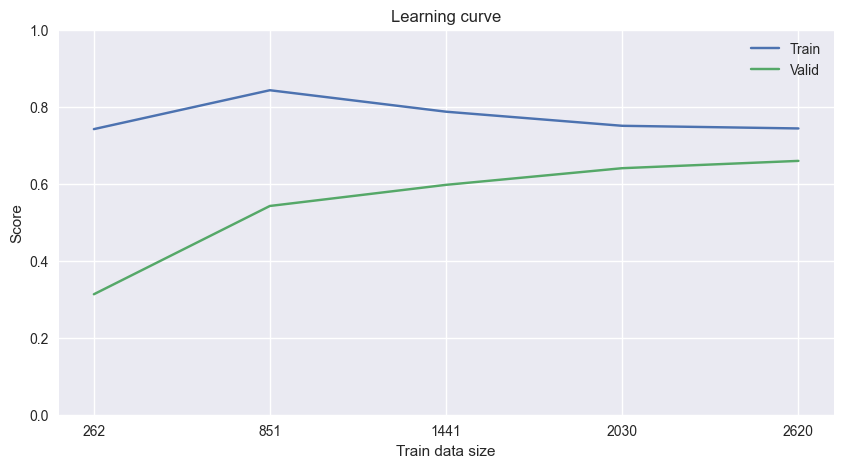

In [46]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

Видно, что в процессе увеличения количества наблюдений в обучающем наборе данных, метрики на тренировочной и валидационной выборках постепенно приближаются друг к другу, то есть уменьшается разброс (*variance*).

Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию `plot_learning_curve()`. У функции будет несколько аргументов: модель, набор данных (X, y), кросс-валидатор, метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

In [47]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели:

* логистическую регрессию,
* дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
* дерево решений без ограничений.

Создадим список, в котором будем хранить эти модели:

In [48]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим *k-fold*-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию `plot_learning_curve()`:

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

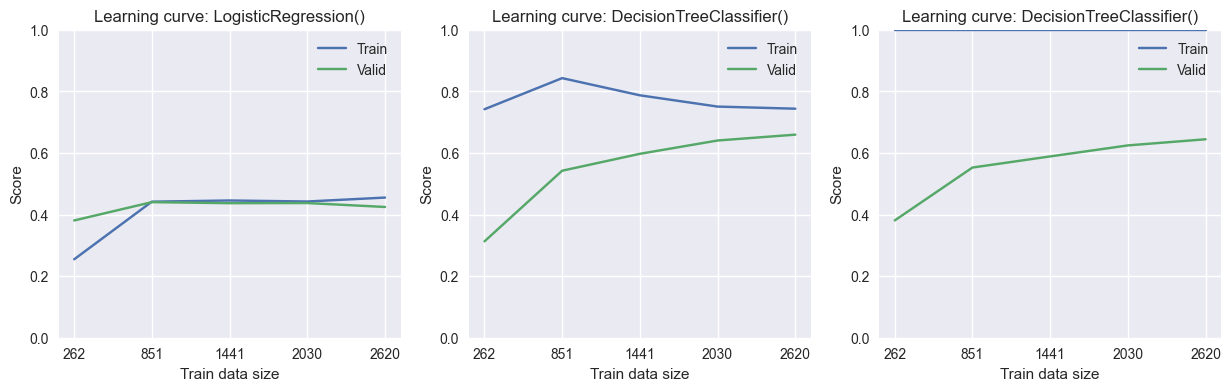

In [49]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

Мы можем легко сравнить три представленные модели между собой. 

* Первый график, построенный для логистической регрессии, говорит нам о том, что для данной модели качество на тренировочных и валидационных фолдах практически одинаково (кривые проходят очень близко друг к другу), то есть переобучения нет. Однако данная модель обладает низким качеством: кривые не превышают даже значения 0.5. Модель является недообученнной.

* Третий график, построенный для дерева решений без ограничений глубины, явно указывает на наличие переобучения: тренировочная кривая всё время находится в области своего максимума — 1, а вот валидационная кривая не может достичь такой высокой отметки.

* Из всех представленных оптимальной является модель дерева решений с ограничениями, кривая обучения которой изображена на втором графике. Тренировочная и валидационная кривые постепенно сходятся к единой отметке качества, и полученная метрика превышает отметку в 0.5.

# <center>Практика</center>

In [50]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [51]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [52]:
print(shoppers_data.shape)

(12330, 18)


In [53]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию `get_dummies()`:

In [54]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


Нам необходимо предсказать целевую переменную **Revenue** — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


C:\Users\user\AppData\Local\Temp\ipykernel_9956\3825417070.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
C:\Users\user\AppData\Local\Temp\ipykernel_9956\3825417070.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
C:\Users\user\AppData\Local\Temp\ipykernel_9956\3825417070.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sessions with

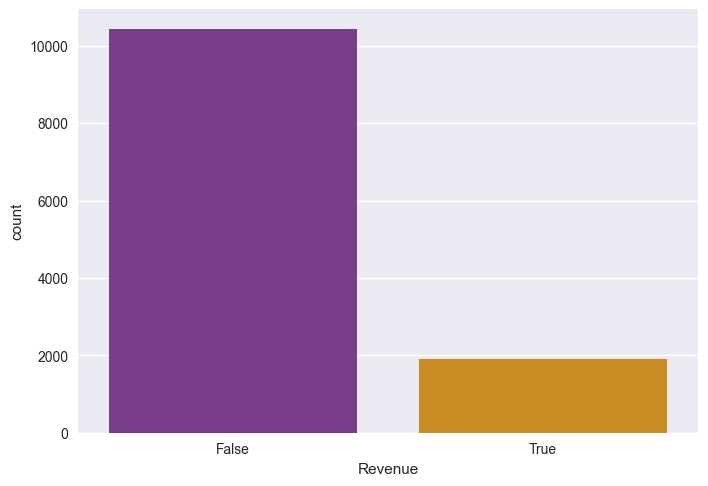

In [55]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно. Условимся, что лучшей будет считаться та модель, у которой значение метрики $F_{1}$ для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений `X` и вектор ответов `y`:

In [56]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Заранее определимся, как мы будем производить контроль качества наших моделей:

* Разделим выборку на тренировочную и тестовую.
* Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

* значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
* значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать *hold-оut*- и *k-fold*-подходы к валидации.

In [58]:
# Задание 6.2

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#Проверим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (9864, 28)
Test shape: (2466, 28)


In [59]:
# Задание 6.3

model = ensemble.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    model, X_train, y_train, cv=skf, scoring='f1', return_train_score=True
) 

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score']))) 
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score']))) #в ответах почему-то 0.65

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.64


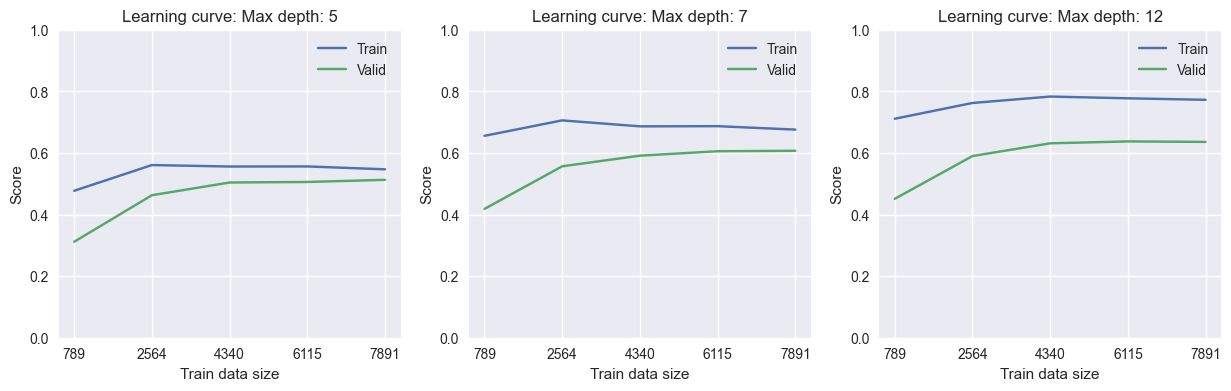

In [60]:
# Задание 6.5

def plot_learning_curve(model, X, y, cv, scoring='f1', ax=None, title=''):
    #Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator = model, #модель
        X = X, #матрица наблюдений X
        y = y, #вектор ответов y
        cv = cv, #кросс-валидатор
        scoring = 'f1' #метрика
    )
    #Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    #Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    #Строим кривую обучения на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label='Train')
    #Строим кривую обучения на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label='Valid')
    #Даём название графику и подписи осям
    ax.set_title('Learning curve: {}'.format(title))
    ax.set_xlabel('Train data size')
    ax.set_ylabel('Score')
    #Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    #Устаналиваем диапазон оси ординат
    ax.set_ylim(0, 1)
    #Отображаем легенду
    ax.legend();

#Список из глубин деревьев
depths = [5, 7, 12]
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку глубин и индексам этого списка
for i, depth in enumerate(depths): #i-текущий индекс, depth — текущая глубина
    #Создаём модель
    model = ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=depth,
        min_samples_leaf=5,
        random_state=42
    )
    #Строим кривую обучению
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'Max depth: {depth}')

In [61]:
# Задание 6.6

model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      2055
        True       0.81      0.45      0.58       411

    accuracy                           0.89      2466
   macro avg       0.85      0.72      0.76      2466
weighted avg       0.88      0.89      0.88      2466



Best threshold = 0.32, F1-Score = 0.68


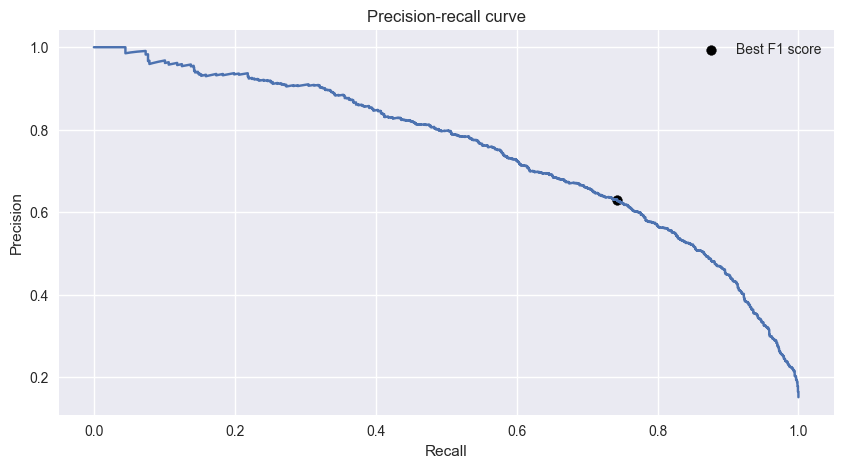

In [62]:
# Задание 6.7

#Создаём модель
model = ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
#Выделяем столбец с вероятностями для класса 1
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума F1
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision)
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даём название графику и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [63]:
# Задание 6.8

#Задаём оптимальный порог вероятностей
threshold_opt = 0.36
#Объекты, для которых вероятность быть классом 1 > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94      2055
        True       0.68      0.69      0.69       411

    accuracy                           0.89      2466
   macro avg       0.81      0.81      0.81      2466
weighted avg       0.90      0.89      0.90      2466

